In [ ]:
'''
주제/키워드가 주어졌을때 다음을 시각화 한다
1. 구글 트렌드
2. 투자
3. 인수
'''

In [331]:
import pandas as pd
import re
import gensim
import pickle
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

In [223]:
# load data
data_folder = '../data/csv_export/'
util_folder = '../util/'
trend_folder = '../data/trends/'
df_organizations = pd.read_csv(data_folder + 'organizations.csv'.format(data_folder), dtype={'first_funding_on': str, 'last_funding_on':str})
df_description = pd.read_csv(data_folder + 'organization_descriptions.csv')
df_funding_rounds = pd.read_csv(data_folder + 'funding_rounds.csv')
df_funds = pd.read_csv(data_folder + 'funds.csv')
df_investments = pd.read_csv(data_folder + 'investments.csv')
df_acq = pd.read_csv(data_folder + 'acquisitions.csv')

Week Wearable technology: (United States)
    year-month  google_count
0      2012-07     14.666667
3      2012-08     12.500000
7      2012-09     13.000000
12     2012-10     12.250000
16     2012-11     17.500000
20     2012-12     16.200000
25     2013-01     15.750000
29     2013-02     19.750000
33     2013-03     20.400000
38     2013-04     19.000000
42     2013-05     23.500000
46     2013-06     24.600000
51     2013-07     27.000000
55     2013-08     28.500000
59     2013-09     27.400000
64     2013-10     28.000000
68     2013-11     31.250000
72     2013-12     32.600000
77     2014-01     60.750000
81     2014-02     48.500000
85     2014-03     55.200000
90     2014-04     58.500000
94     2014-05     53.000000
98     2014-06     58.600000
103    2014-07     61.250000
107    2014-08     63.600000
112    2014-09     73.750000
116    2014-10     70.250000
120    2014-11     75.600000
125    2014-12     66.750000
..         ...           ...
133    2015-02     66.750000
1

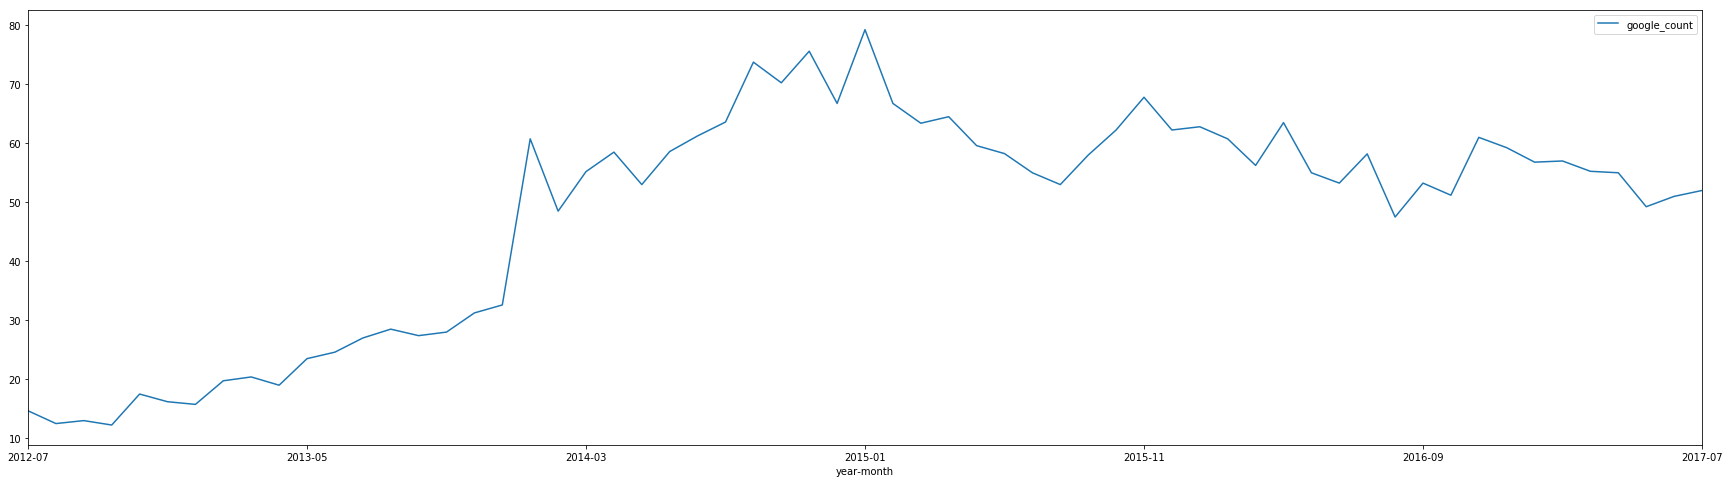

In [413]:
keyword = 'wearable'
f = open(trend_folder + keyword + '.csv')
df_google_trend = pd.read_csv(trend_folder + keyword + '.csv', header = 1)  
column1, column2 = df_google_trend.columns
print column1, column2
df_google_trend['google_count'] = df_google_trend[column2].groupby(df_google_trend[column1].str[:7]).transform('mean')

df_google_trend['year-month'] = df_google_trend[column1].str[:7]
df_google_trend = df_google_trend.loc[:,['year-month', 'google_count']]
df_google_trend = df_google_trend.drop_duplicates()
df_google_trend.columns = ['year-month', 'google_count']
df_google_trend.plot(kind = 'line', x = df_google_trend['year-month'], figsize = (30, 8))

In [437]:
def visualize(keyword, words, expand = False, plot_all = False, start_date = '2004-01'):
    fig = plt.figure()
    condition = 'first_funding_on'
    
#     f = open(trend_folder + keyword + '.csv')
#     df_google_trend = pd.read_csv(trend_folder + keyword + '.csv', header = 1)  
#     df_google_trend.columns = ['year-month', 'google_count']
#     if plot_all:
#         df_google_trend.plot(kind = 'line', x = df_google_trend['year-month'], figsize = (30, 8))
    f = open(trend_folder + keyword + '.csv')
    df_google_trend = pd.read_csv(trend_folder + keyword + '.csv', header = 1)  
    column1, column2 = df_google_trend.columns
    print column1, column2
    df_google_trend['google_count'] = df_google_trend[column2].groupby(df_google_trend[column1].str[:7]).transform('mean')

    df_google_trend['year-month'] = df_google_trend[column1].str[:7]
    df_google_trend = df_google_trend.loc[:,['year-month', 'google_count']]
    df_google_trend = df_google_trend.drop_duplicates()
    df_google_trend.columns = ['year-month', 'google_count']
    if plot_all:
        df_google_trend.plot(kind = 'line', x = df_google_trend['year-month'], figsize = (30, 8))

    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')
        
    # expand word set if necessary
    # train 된 word2vec 을 사용하여 관련도가 높은 단어들을 포함한다
    final_words = []
    if type(words) == str:
        words = [words]
    for word in words:
        if ' ' in word:
            word = word.replace(' ', '_')
        if expand:
            _words = model.most_similar(word)
            _words = [str(_word) for _word, sim in _words]
            final_words.extend(_words)
        final_words.append(word)
    final_words = list(set(final_words))

    # choose companies that have relevant words
    companies = []
    for word in final_words:
        _companies = word2company.get(word, [])
        companies.extend(_companies)
    companies = list(set(companies))

    # 회사를 시기 별로 정리한다
    # 1. funding
    df_companies = df_organizations[df_organizations['uuid'].isin(companies)]
    df = pd.DataFrame()
    df['date'] = df_companies["first_funding_on"]
    df = df[~df['date'].isnull()]
    df['year-month'] = df['date'].str[:7]
    funding = df.groupby(df['year-month']).size().reset_index()
    funding.columns = ['year-month', 'funding_count']
    funding = funding[funding['year-month'] >= start_date]
    if plot_all:
        funding.plot(kind = 'bar', x = funding['year-month'], figsize = (30, 8))
    
    
    df_merged = pd.merge(df_google_trend, funding, on = 'year-month', how = 'outer')
    
    # 2. acquisition
    df = df_acq[df_acq['acquiree_uuid'].isin(companies)]
    df = df.loc[:,['acquired_on']]
    df['year-month'] = df['acquired_on'].str[:7]
    acq = df.groupby(df['year-month']).size().reset_index()
    acq.columns = ['year-month', 'acq_count']
    acq = acq[acq['year-month'] >= start_date]
    if plot_all:
        acq.plot(kind = 'bar', x = acq['year-month'], figsize = (30, 8))
    
    div_by = 100 / (df_merged['funding_count'].max() + 1)
    df_merged['google_count'] /= div_by

    df_merged = pd.merge(df_merged, acq, on = 'year-month', how = 'outer')
    df_merged = df_merged.sort_values(['year-month'])
    df_merged['year'] = np.where(df_merged['year-month'].str[5:7] == '01', df_merged['year-month'].str[:4], '')
    ax = df_merged[['year-month', 'google_count']].plot(x = df_merged['year'], linestyle = '-', color = 'black')
    df_merged[['year-month', 'funding_count', 'acq_count']].plot(x = df_merged['year'], kind = 'bar', rot = 0, ax = ax, fontsize = 25, figsize = (30, 8), color = ['blue', 'red']).legend(loc = 2, fontsize = 20, labels = ['google trend', '# funding', '#M&A'])
    
    print('Google Trend: {}\n Companies with keywords:{}'.format(keyword, final_words))
    print df_merged

Month Augmented reality: (United States)
Google Trend: augmented_reality
 Companies with keywords:['ar', 'augmented_reality']
    year-month  google_count  funding_count  acq_count  year
0      2004-01           1.0            NaN        NaN  2004
1      2004-02           1.2            NaN        NaN      
2      2004-03           1.4            NaN        NaN      
3      2004-04           1.0            NaN        NaN      
4      2004-05           1.2            NaN        NaN      
5      2004-06           0.9            NaN        NaN      
6      2004-07           1.0            NaN        NaN      
7      2004-08           1.1            NaN        NaN      
8      2004-09           1.3            NaN        NaN      
9      2004-10           1.2            NaN        NaN      
10     2004-11           1.2            NaN        NaN      
11     2004-12           0.8            NaN        NaN      
12     2005-01           1.0            2.0        NaN  2005
13     2005-02      

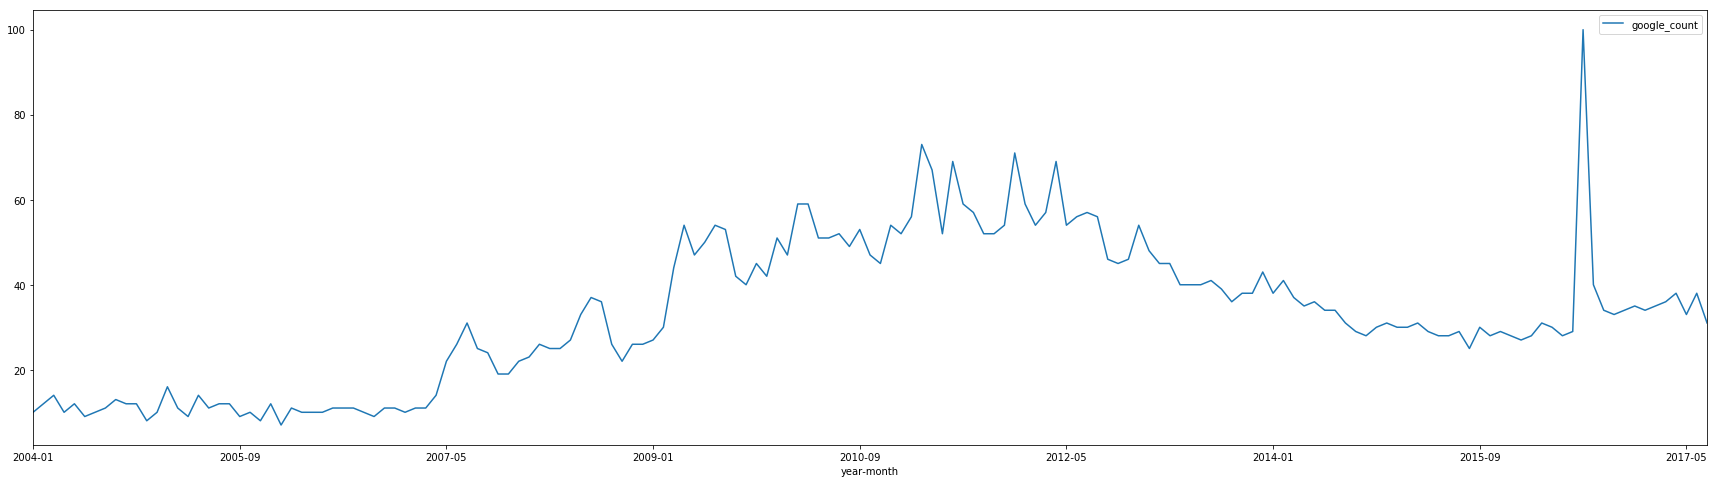

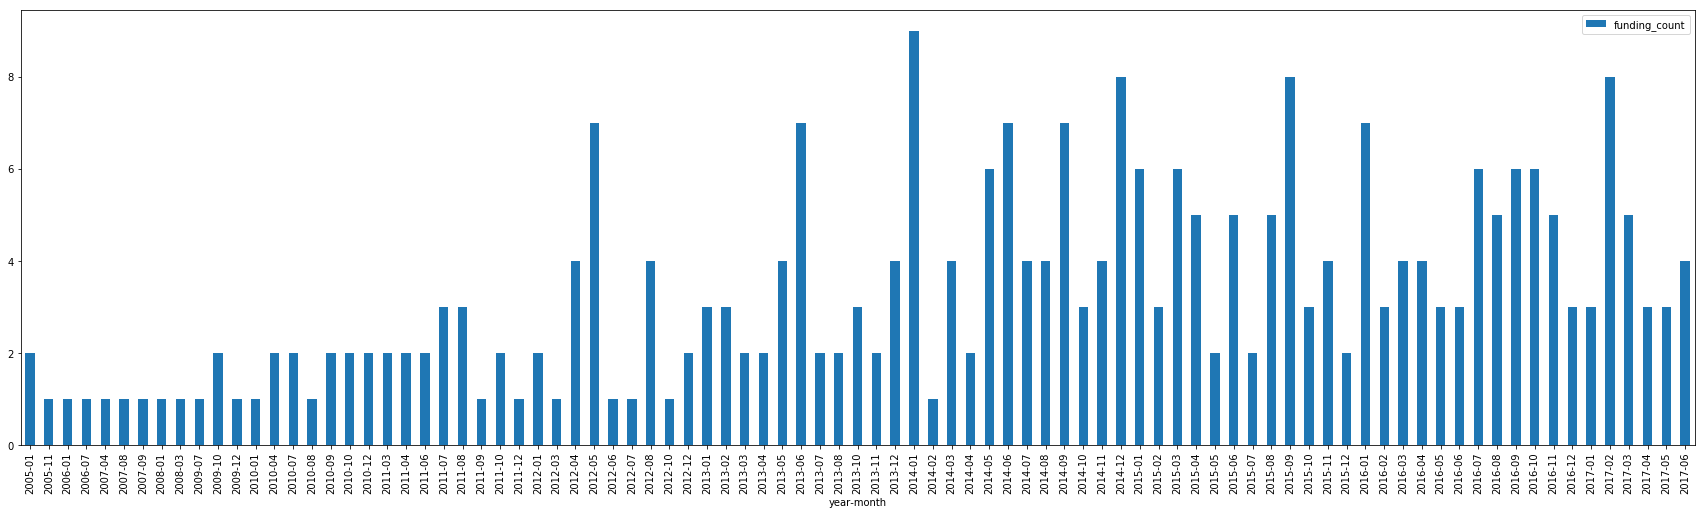

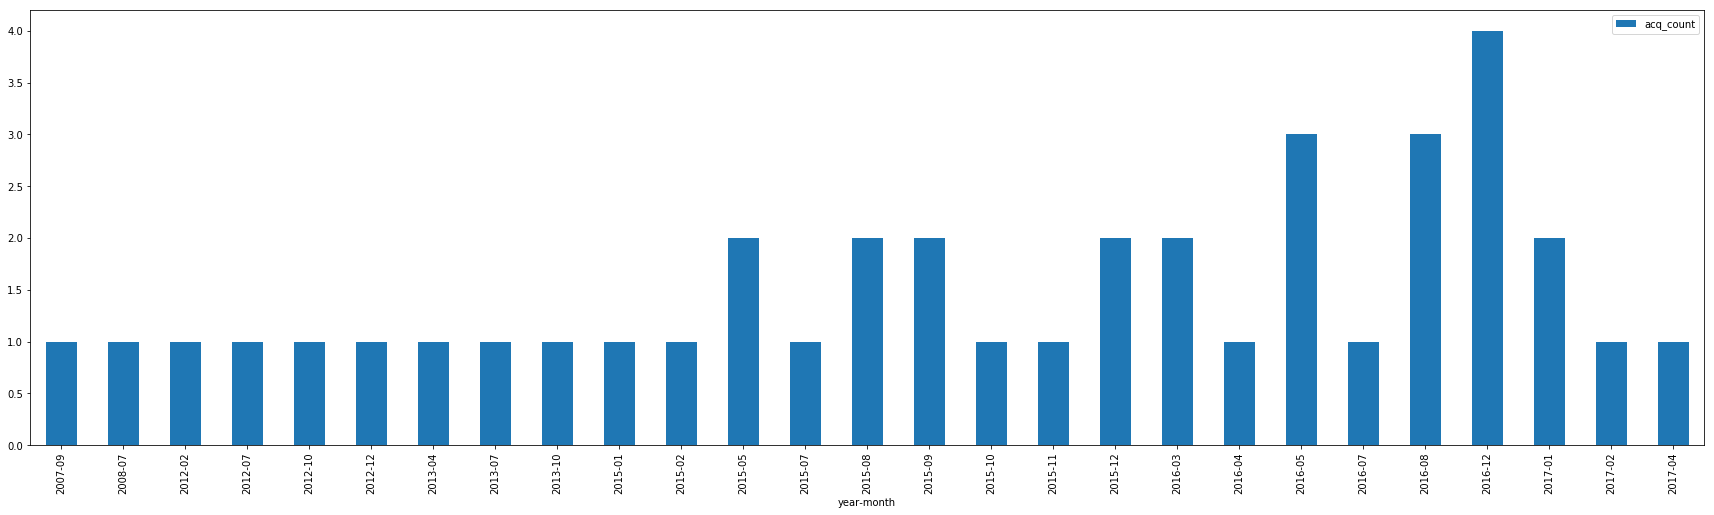

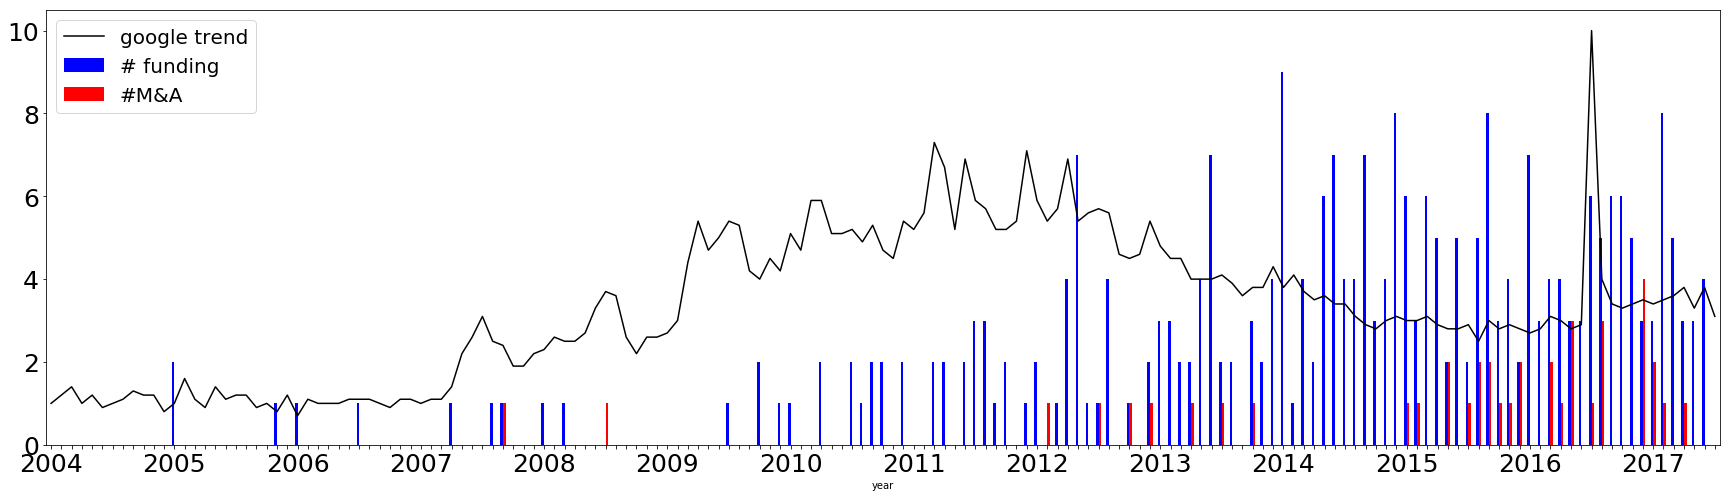

In [438]:
visualize('augmented_reality', ['augmented_reality', 'ar'], expand = False, plot_all = True)

Month wearable technology: (Worldwide)
Google Trend: wearable
 Companies with keywords:['wearable_tech', 'wearables', 'smartwatch', 'smart_glasses', 'wearable_device', 'wrist_worn', 'wearable_sensor', 'wearable_devices', 'wearable', 'wearable_technology']
    year-month  google_count  funding_count  acq_count  year
0      2004-01           5.2            2.0        NaN  2004
1      2004-02           3.4            NaN        NaN      
2      2004-03           4.4            NaN        NaN      
3      2004-04           4.2            NaN        NaN      
4      2004-05           1.0            NaN        NaN      
5      2004-06           1.0            NaN        NaN      
6      2004-07           2.2            NaN        NaN      
7      2004-08           4.8            NaN        NaN      
8      2004-09           4.2            NaN        NaN      
9      2004-10           2.2            NaN        NaN      
10     2004-11           3.4            NaN        1.0      
11     2004-

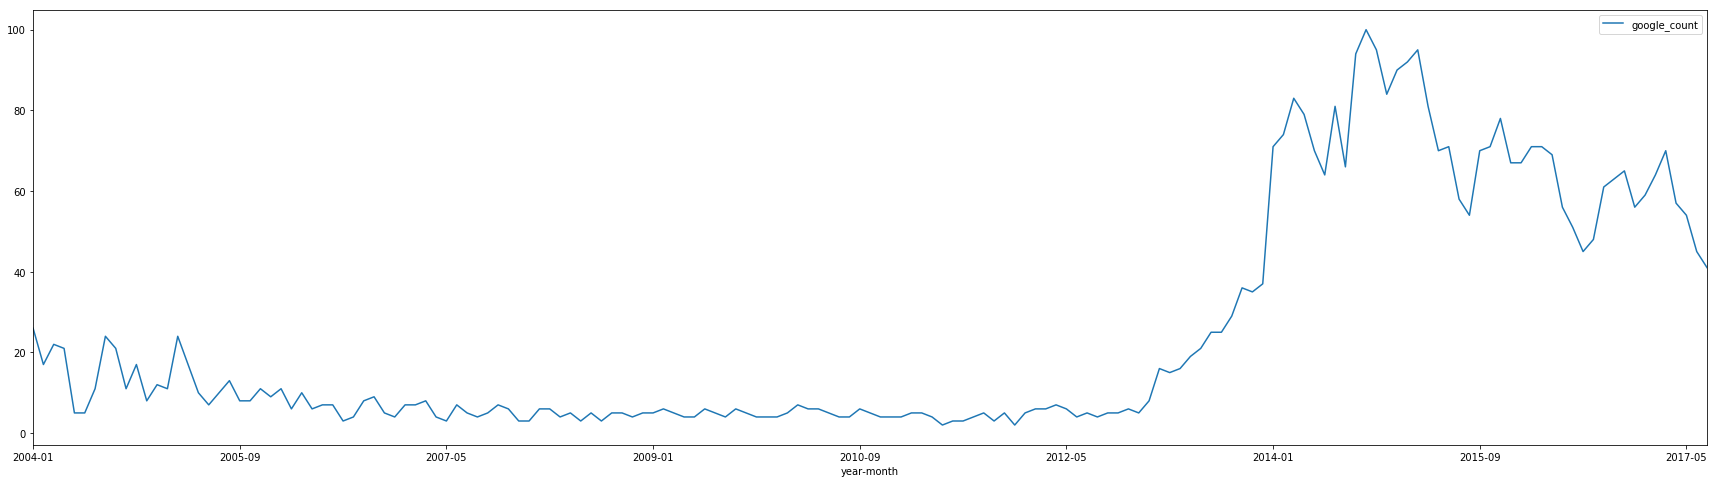

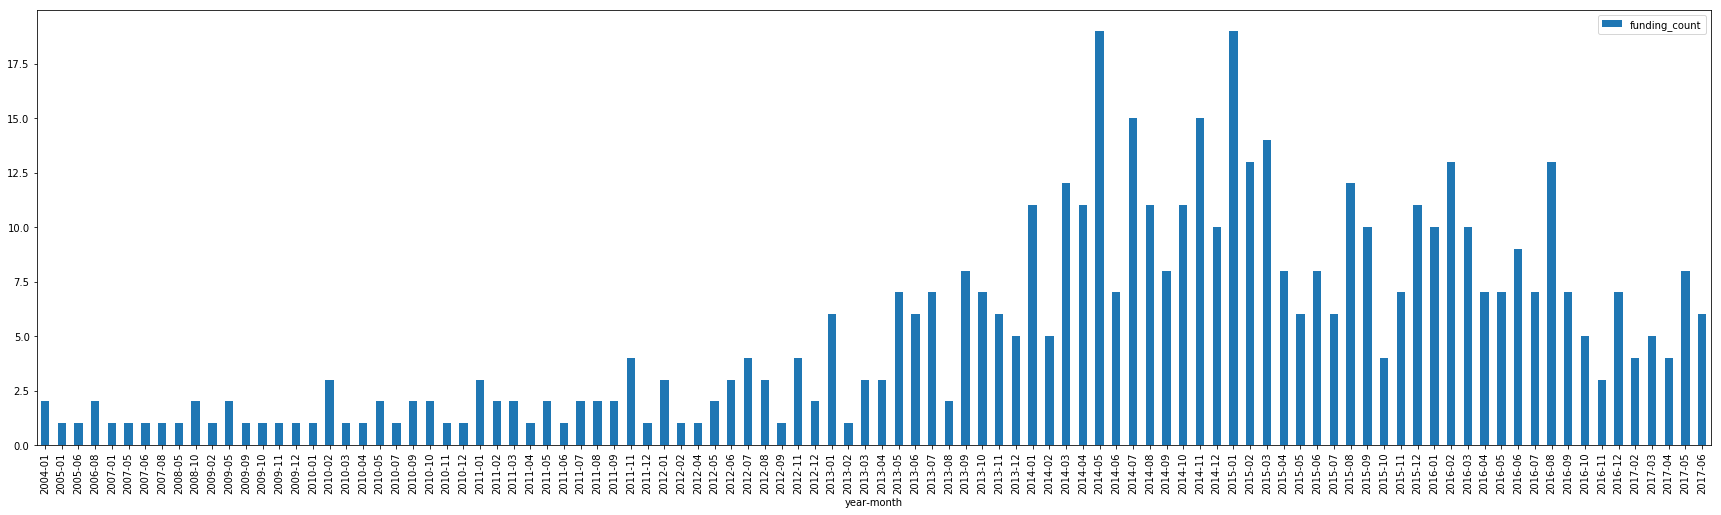

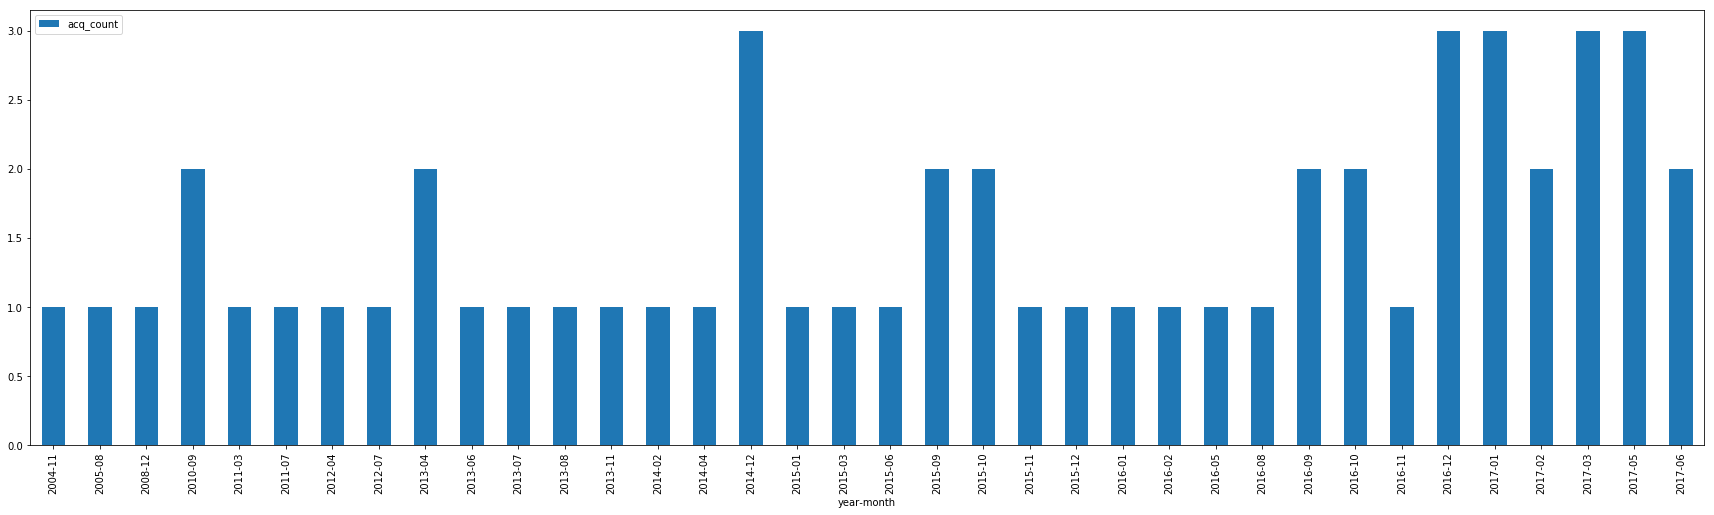

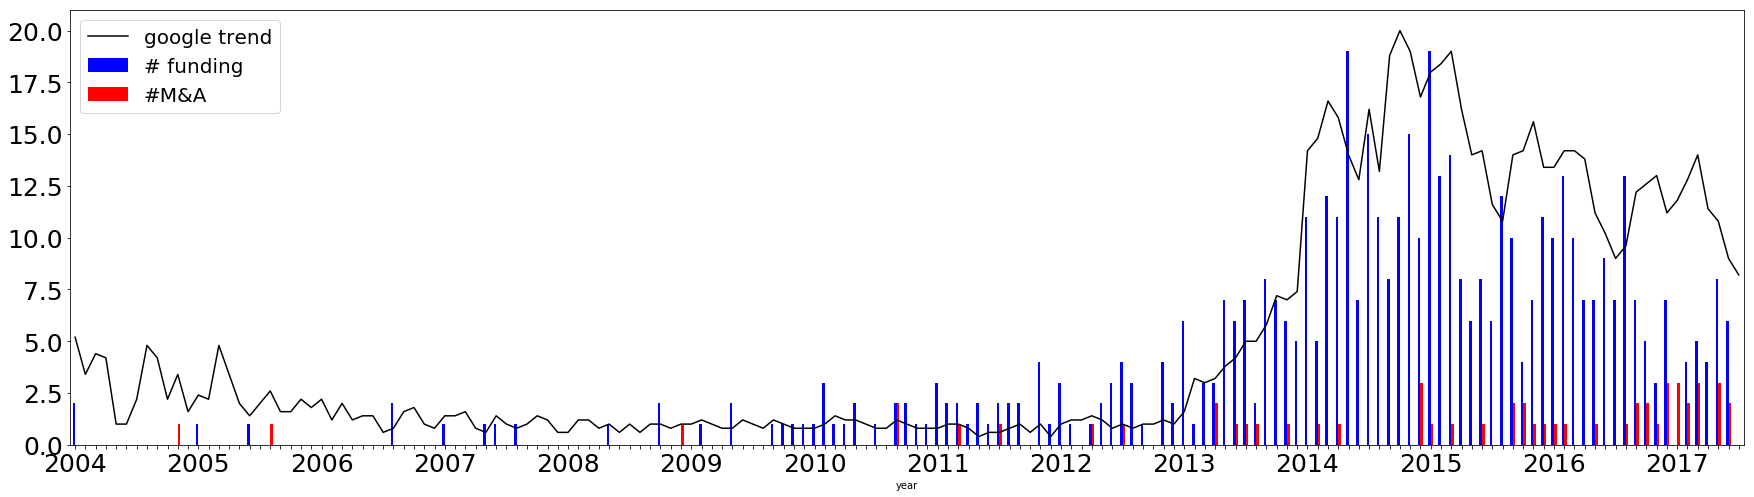

In [439]:
visualize('wearable', ['wearable', 'wearables', 'smartwatch', 'smart_glasses', 'wearable_device', 'wrist_worn', 'wearable_sensor', 'wearable_devices', 'wearable', 'wearable_tech', 'wearable_technology'], plot_all = True)

Month iot: (Worldwide)
Google Trend: iot
 Companies with keywords:['iot', 'wearable_technology', 'mobility', 'iot_devices', 'smart_grid', 'connected_car', 'big_data', 'cloud_computing', 'industrial_iot', 'iiot', 'embedded_systems']
    year-month  google_count  funding_count  acq_count  year
0      2004-01          2.40            6.0        2.0  2004
1      2004-02          2.40            5.0        2.0      
2      2004-03          2.40            4.0        NaN      
3      2004-04          2.40            NaN        NaN      
4      2004-05          1.92            2.0        NaN      
5      2004-06          2.88            3.0        NaN      
6      2004-07          2.88            NaN        NaN      
7      2004-08          1.92            3.0        NaN      
8      2004-09          2.40            3.0        NaN      
9      2004-10          2.40            1.0        1.0      
10     2004-11          2.40            3.0        NaN      
11     2004-12          2.40        

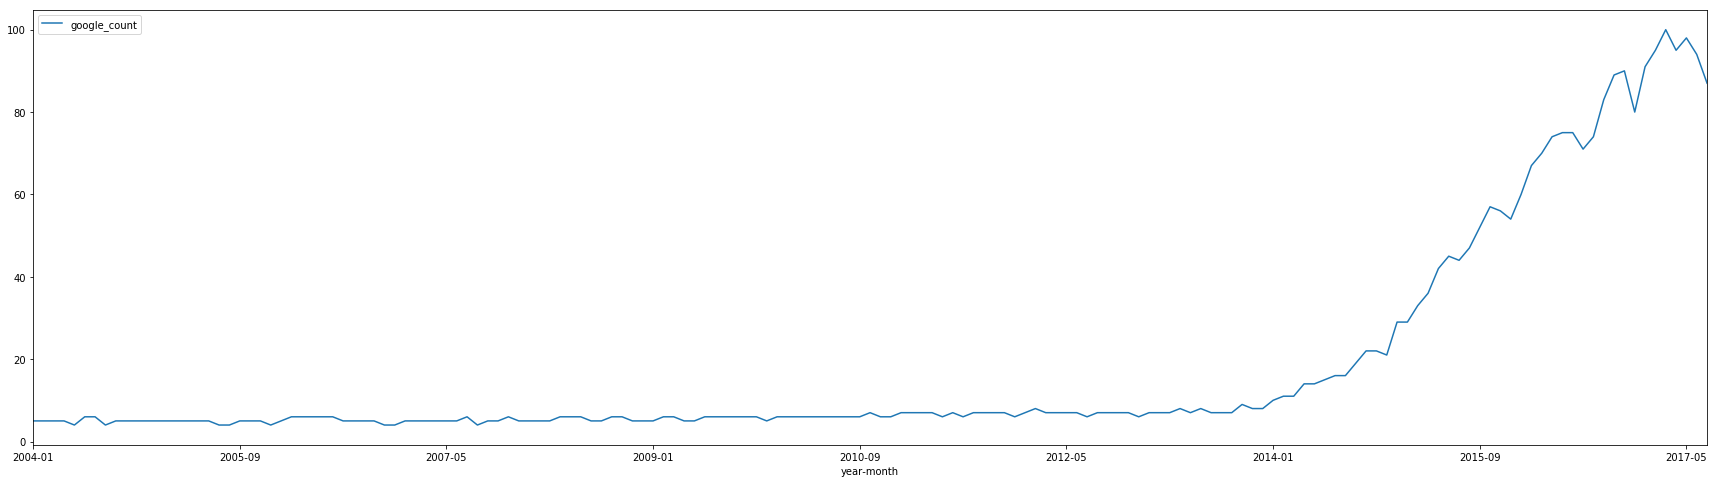

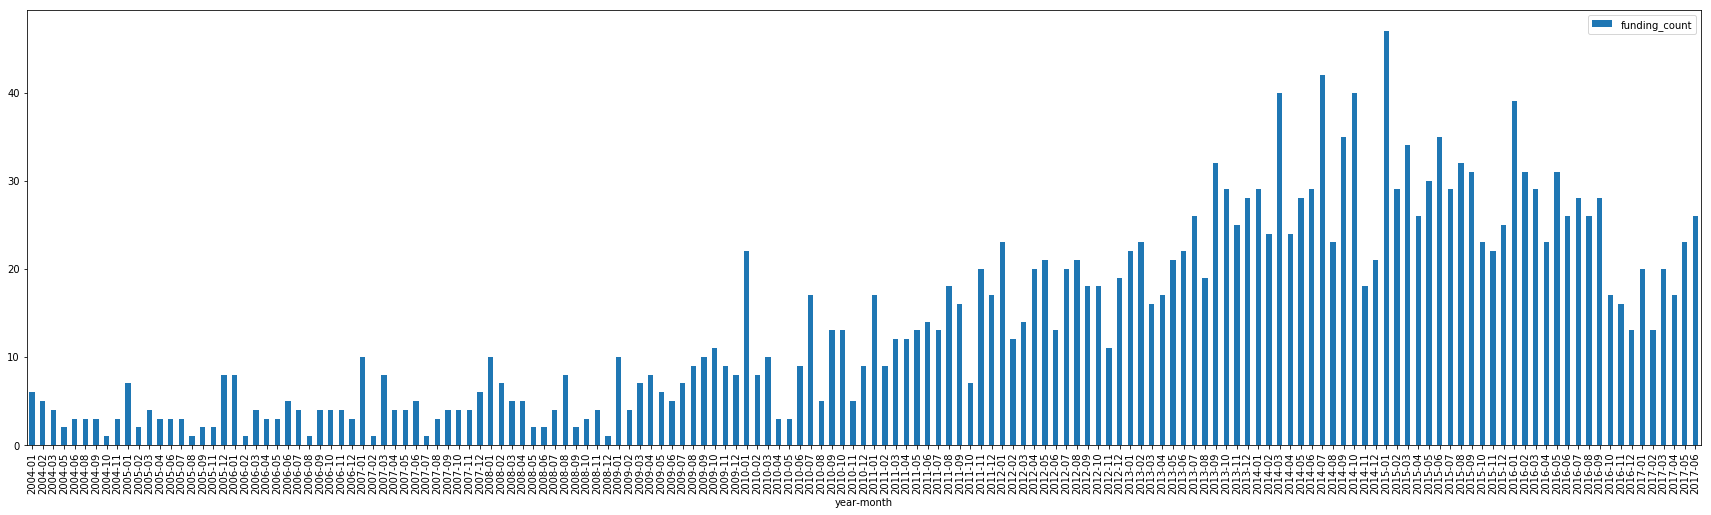

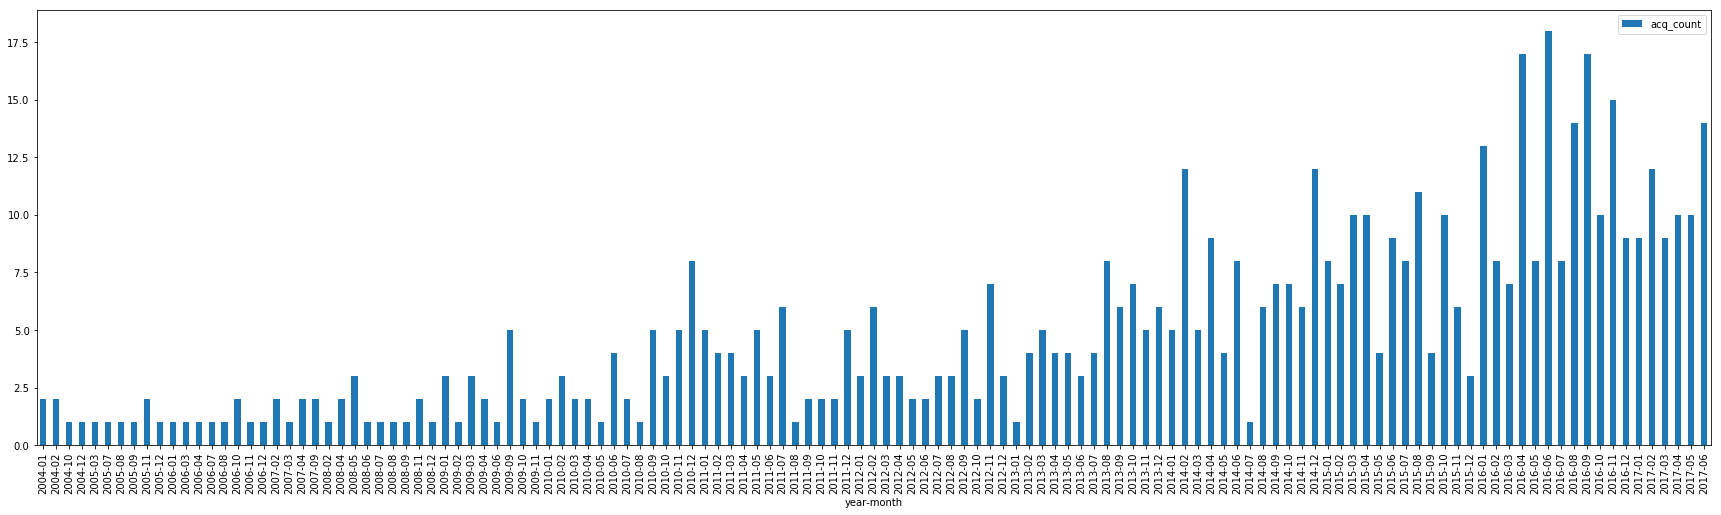

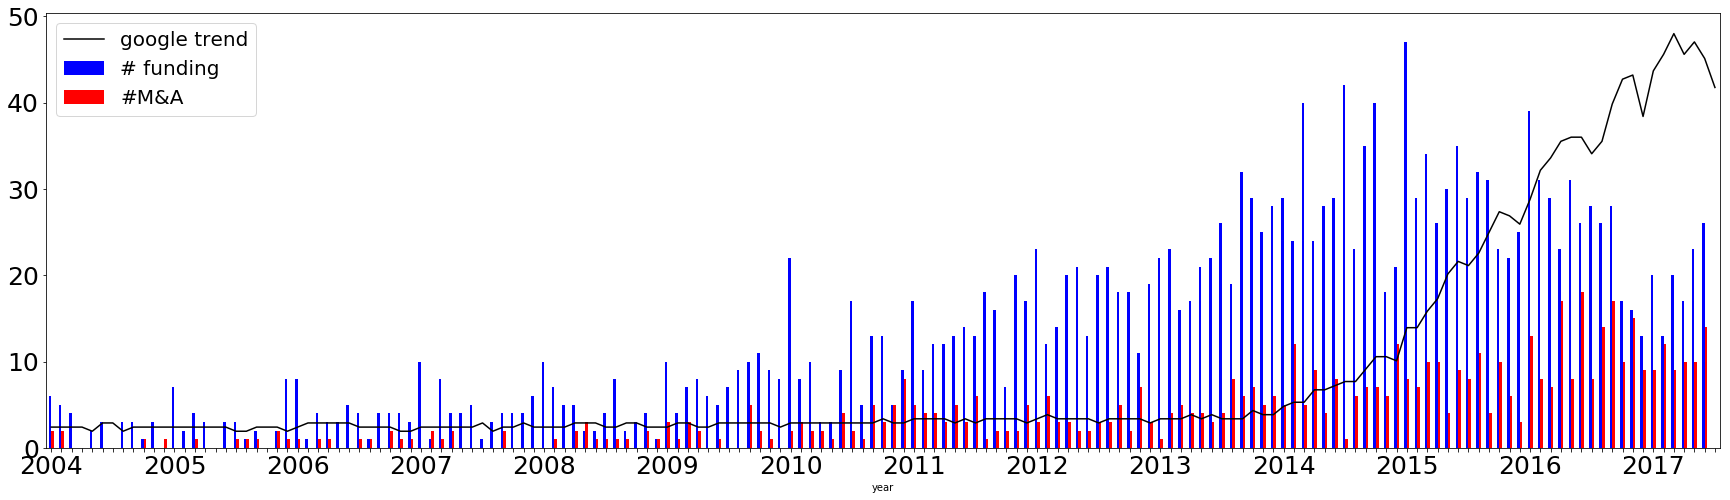

In [440]:
visualize('iot', 'iot', expand = True, plot_all = True)